In [1]:
%matplotlib notebook
import warnings
import numpy as np
import matplotlib.pyplot as plt
import hera_cal
import glob, os
import cPickle as cp
import aipy
import time

In [2]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

# The A matrix

Generate the A matrix (the system of equations) to then study the properties of the system through SVD analysis. The system of equations represented by the A matrix is variable-separable into the real and imaginary parts. 

The **real part represents the absolute gain solutions** and the **imaginary part represents the phase of the gain solutions**.

In [3]:
def genA(redbls):
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    # number of measurements = total number of baselines
    allbls = [bl for red in redbls for bl in red]
    M = len(allbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = (1+1j)
            A[i,pair[1]] = (1-1j)
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]+.5,v[1]))

def plot_redbl(redbls):
    for a1,a2 in redbls:
        plt.plot([antpos[a1][0],antpos[a2][0]],[antpos[a1][1],antpos[a2][1]],'k-')

In [4]:
A = genA(redbls)
M,N = np.shape(A)
print M,N

666 100


<IPython.core.display.Javascript object>


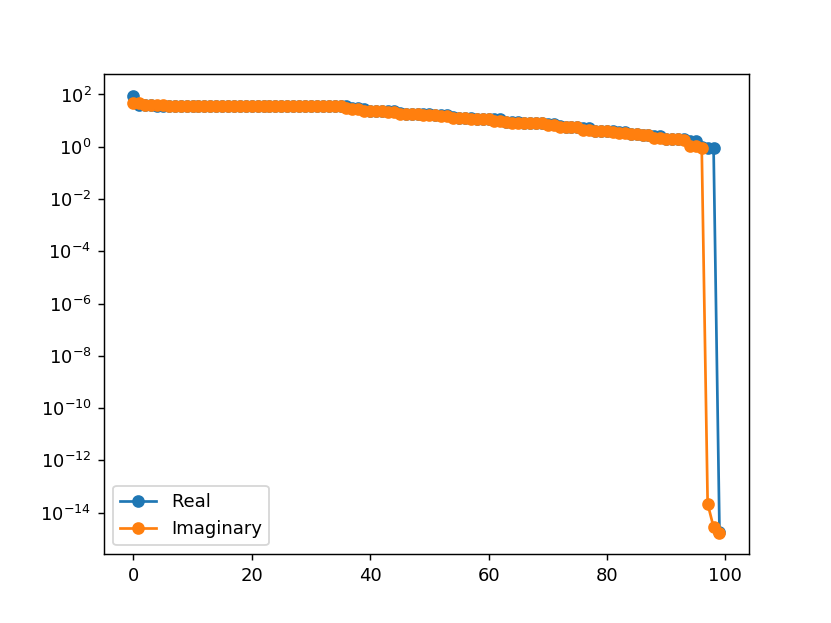

In [5]:
# Find the SVD of the real and imaginary parts of A

Mr = np.dot(np.real(A.T), np.real(A))
Mi = np.dot(np.imag(np.conjugate(A.T)), np.imag(A))

Ur,Sr,Vr = np.linalg.svd(Mr)
Ui,Si,Vi = np.linalg.svd(Mi)

plt.figure()
plt.semilogy(Sr,'o-',label='Real')
plt.semilogy(Si,'o-',label='Imaginary')
plt.legend()
plt.show()

# Degeneracies

To check if the degenerate modes you see in the above eigen spectrum are really the absolute gain, phase and phase slope- add those equations back as constraints and see if the degenerate vectors disappear.

$$\Sigma \eta_i = 0$$

$$\Sigma \phi_i = 0$$

$$\Sigma r_{x,i}\phi_i = 0$$

$$\Sigma r_{y,i}\phi_i = 0$$

<IPython.core.display.Javascript object>


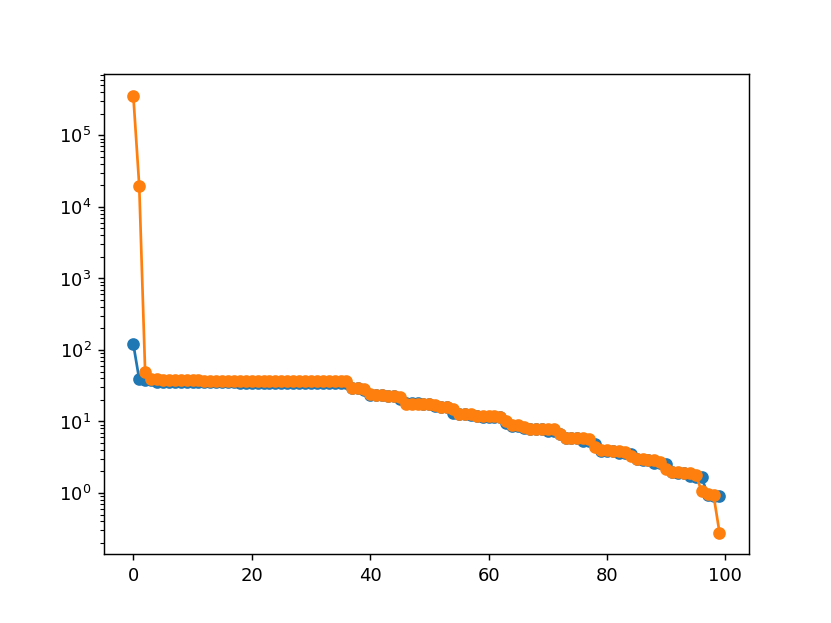

In [6]:
# Add constraints

Acond = np.zeros([M+3,N],dtype=np.complex)
Acond[:M,:] = A

for ant in range(Nants):
    Acond[M, ant] = (1+1j)
    Acond[M+1, ant] = 1j*antpos[ant][0]
    Acond[M+2, ant] = 1j*antpos[ant][1]
    
Mconr = np.dot(np.real(Acond.T), np.real(Acond))
Mconi = np.dot(np.imag(np.conjugate(Acond.T)), np.imag(Acond))

Ucr,Scr,Vcr = np.linalg.svd(Mconr)
Uci,Sci,Vci = np.linalg.svd(Mconi)

plt.figure()
plt.semilogy(Scr,'o-',label='Real')
plt.semilogy(Sci,'o-',label='Imaginary')

# Shortest Baseline Separation

Calibrate only the very shortest baselines of an array.

**Motivation:** 
1. The shorest baseslines see the brightest sky and hence have the largest amplitude.
2. They are most redundant pairs any configuration will have.

**Caveats:**
1. They seem to not be very redundant from current observations.

<IPython.core.display.Javascript object>


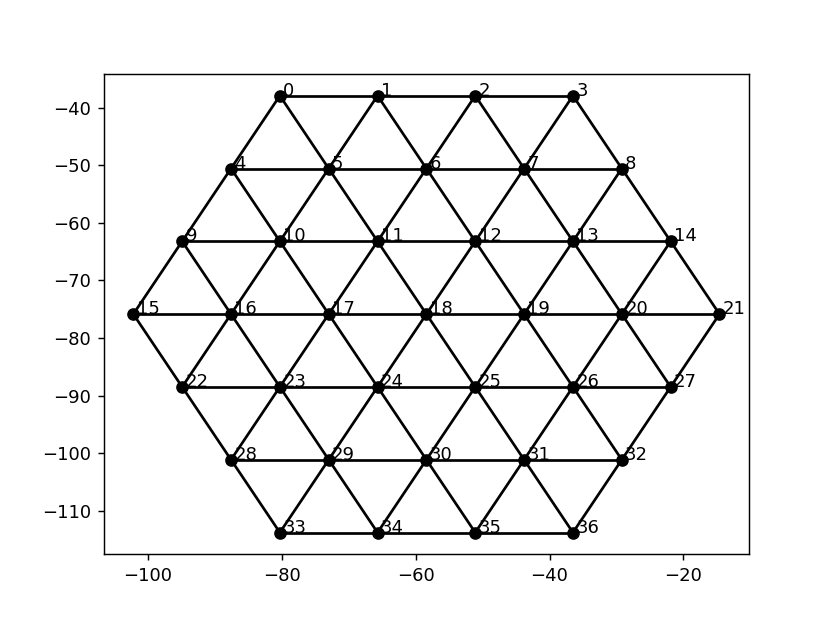

In [7]:
plt.figure()
plot_ants(antpos)
plot_redbl(redbls[0]); plot_redbl(redbls[1]); plot_redbl(redbls[2])

90 40


<IPython.core.display.Javascript object>


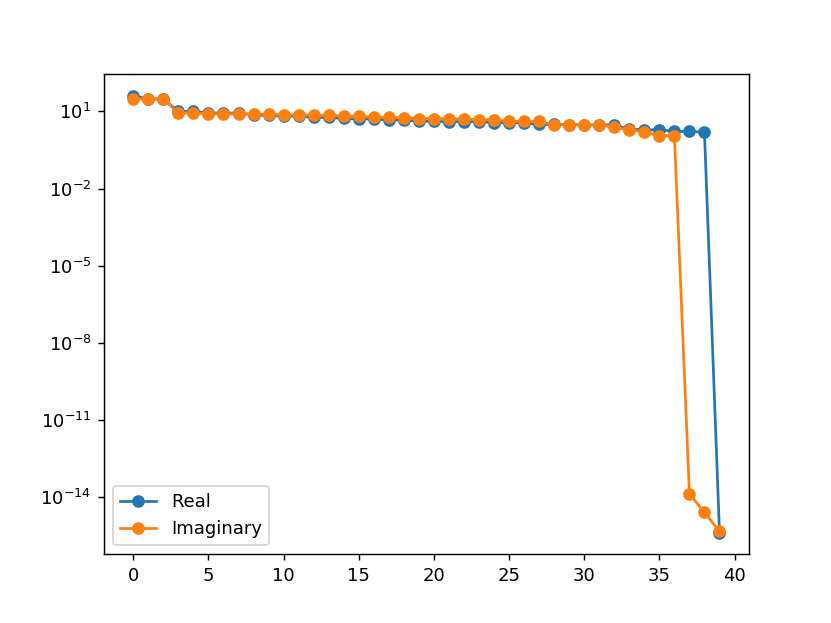

In [9]:
sub_bls = np.array([redbls[0],redbls[1],redbls[2]])
At = genA(sub_bls)
Mt,Nt = np.shape(At)
print Mt,Nt

# Find the SVD of the real and imaginary parts of A

Mrt = np.dot(np.real(At.T), np.real(At))
Mit = np.dot(np.imag(np.conjugate(At.T)), np.imag(At))

Urt,Srt,Vrt = np.linalg.svd(Mrt)
Uit,Sit,Vit = np.linalg.svd(Mit)

plt.figure()
plt.semilogy(Srt,'o-',label='Real')
plt.semilogy(Sit,'o-',label='Imaginary')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


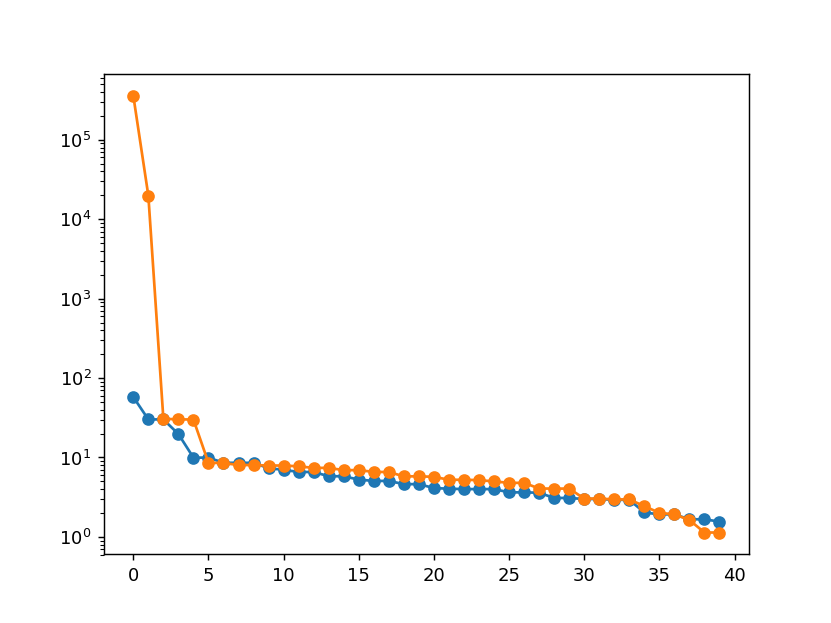

In [10]:
# Add constraints

Acond = np.zeros([Mt+3,Nt],dtype=np.complex)
Acond[:Mt,:] = At

for ant in range(Nants):
    Acond[Mt, ant] = (1+1j)
    Acond[Mt+1, ant] = 1j*antpos[ant][0]
    Acond[Mt+2, ant] = 1j*antpos[ant][1]
    
Mconr = np.dot(np.real(Acond.T), np.real(Acond))
Mconi = np.dot(np.imag(np.conjugate(Acond.T)), np.imag(Acond))

Ucr,Scr,Vcr = np.linalg.svd(Mconr)
Uci,Sci,Vci = np.linalg.svd(Mconi)

plt.figure()
plt.semilogy(Scr,'o-',label='Real')
plt.semilogy(Sci,'o-',label='Imaginary')

# Covariance Matrix

The covariance of the gain solutions is given by: 

$$Cov(X) = (A^{\dagger}A)^{-1}$$

But we don't need the full covariance matrix- we want to understand just the covariances in the gain parameters.

## Marginalized covariance

The gain covariances are given by the mariginalized covariance- the covariance you get by integrating over all the possible visibility solutions. 

*Ignore the brief period in your life that you thought should be conditional covariance. Conditional covariance would have been right if you were picking the visibility solution from a model or fixing it apriori.*

*Footnote*: Refer to the tutorial notebook **Logcal and Covariance Matrices.ipynb**

### Math

**The columns-rows of the full covariance matrix that correspond to the marginalized variables. Drop others.**

<IPython.core.display.Javascript object>


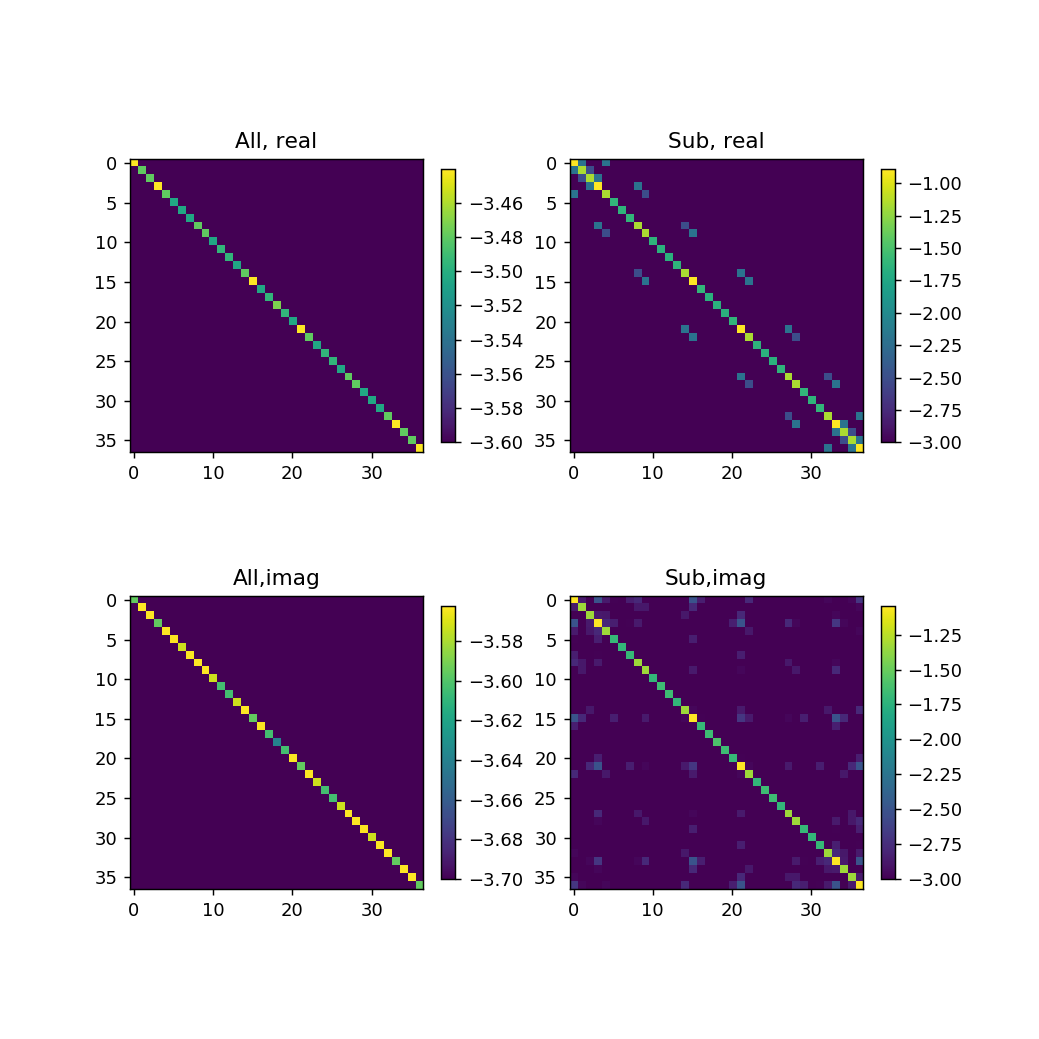

In [10]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('All, real')
covr = np.linalg.pinv(Mr)[:Nants,:Nants]
plt.imshow(np.log(np.abs(covr)),vmin=-3.6)
#plt.imshow(np.log(np.abs(np.real(Acov))),vmin=-2)
plt.colorbar(shrink=0.75)
plt.subplot(222)
plt.title('Sub, real')
covtr = np.linalg.pinv(Mrt)[:Nants,:Nants]
plt.imshow(np.log(np.abs(covtr)),vmin=-3)
#plt.imshow(np.log(np.abs(np.real(Atcov))),vmin=-3)
plt.colorbar(shrink=0.75)

plt.subplot(223)
plt.title('All,imag')
covi = -1*np.linalg.pinv(Mi)[:Nants,:Nants]
plt.imshow(np.log(np.abs(covi)),vmin=-3.7)
#plt.imshow(np.imag(Acov),cmap='PiYG',vmax=2,vmin=-2)
plt.colorbar(shrink=0.75)
plt.subplot(224)
plt.title('Sub,imag')
covti = -1*np.linalg.pinv(Mit)[:Nants,:Nants]
plt.imshow(np.log(np.abs(covti)),vmin=-3)
#plt.imshow(np.imag(Atcov),cmap='PiYG',vmin=-4,vmax=4)
plt.colorbar(shrink=0.75)

# Variance of Gain Parameters

In the above plot the diagonal of the matrix- just the variance has structure. The variance is not the same for all the gains. I hypothesize that this variance is related to the *redundant calibratability* of the antenna. To explain that invented term I invent the definition below:

### Calibration coefficient

$$\Sigma N_{rb} * N_{a}$$

- $N_a$ is number of times that antenna is involved in a baseline seperation
- $N_{rb}$ is the total number of baseline pairs of that separation

In [11]:
def calib_coeff(antenna,redbls):
    #Number of times antenna is involved in that redundant set
    Na = np.array([l.count(antenna) for l in [[ant for pair in bls for ant in pair] for bls in redbls]])
    Nbl = np.array([len(bls) for bls in redbls])
    return np.sum(Nbl*Na)

<IPython.core.display.Javascript object>


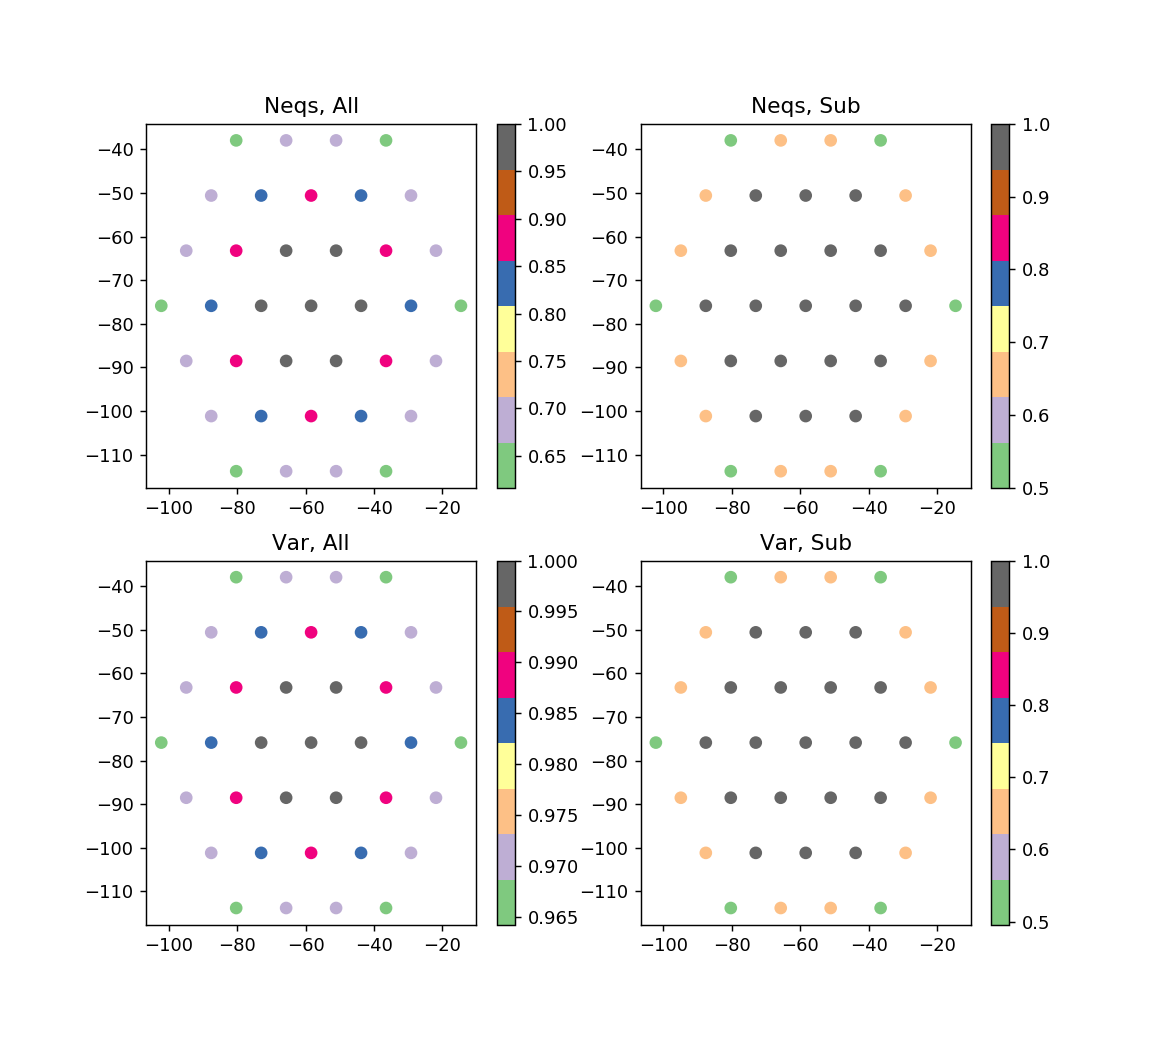

In [12]:
#neqs = np.ones([Nants,Nants])
#neqs_sub = np.ones([Nants,Nants])

neqs = np.zeros(Nants)
neqs_sub = np.zeros(Nants)
for a in range(Nants):
    neqs[a] = calib_coeff(a,redbls)
    neqs_sub[a] = calib_coeff(a,sub_bls)
    
x = [v[0] for v in antpos.values()]
y = [v[1] for v in antpos.values()]

plt.figure(figsize=(9,8))
plt.subplot(221)
plt.title('Neqs, All')
plt.scatter(x,y,c=neqs/np.max(neqs),cmap='Accent')
#plt.imshow(np.log(neqs),vmin=6)
plt.colorbar()
plt.subplot(222)
plt.title('Neqs, Sub')
plt.scatter(x,y,c=neqs_sub/np.max(neqs_sub),cmap='Accent')
#plt.imshow(np.log(neqs_sub),vmin=4)
plt.colorbar()
plt.subplot(223)
plt.title('Var, All')
var_all = np.diag(covr)+np.diag(covi)
plt.scatter(x,y,c=np.min(var_all)/var_all,cmap='Accent')
plt.colorbar()
plt.subplot(224)
plt.title('Var, Sub')
var_sub = np.diag(covtr)+np.diag(covti)
plt.scatter(x,y,c=np.min(var_sub)/var_sub,cmap='Accent')#cmap='Spectral')
plt.colorbar()
plt.show()

In [ ]:
5.66/1.25

# Incrementally longer baselines

<IPython.core.display.Javascript object>


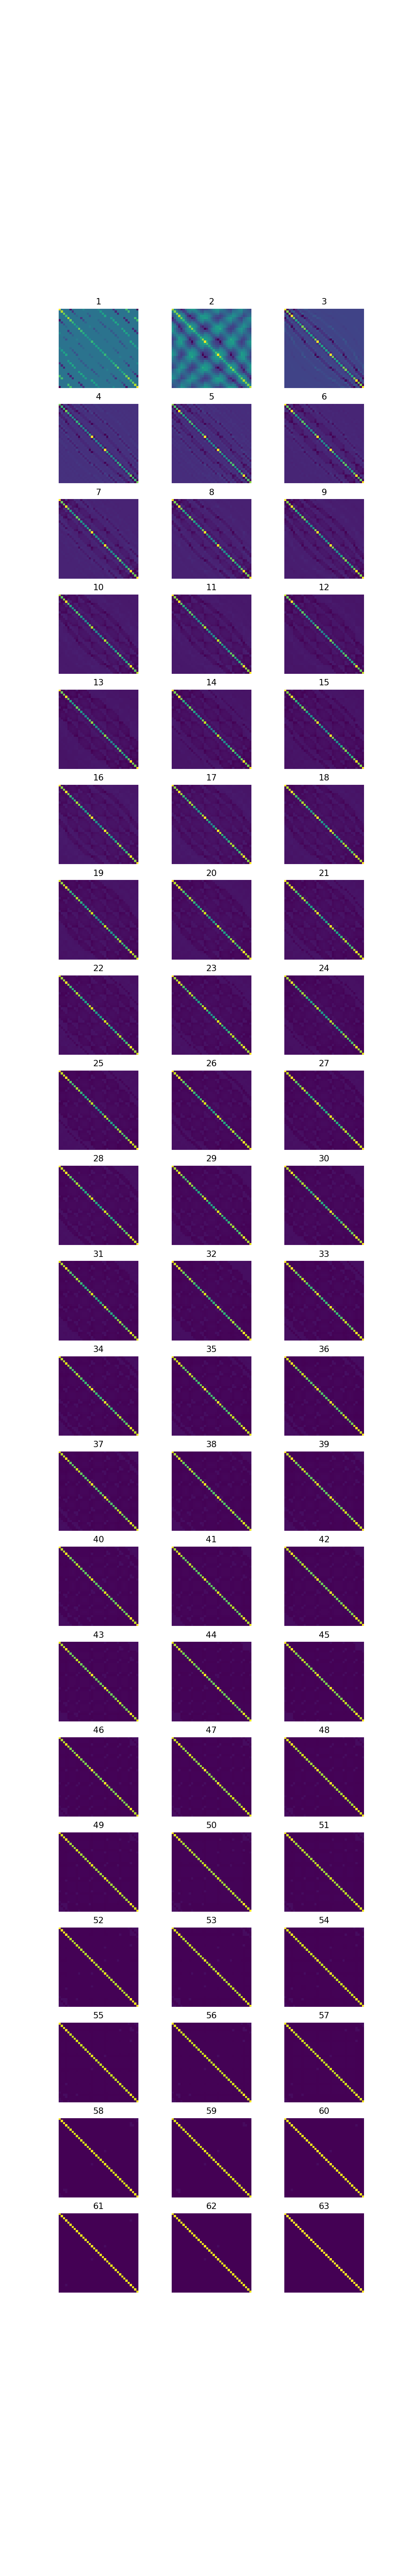

In [13]:
plt.figure(figsize=(8,50))

sub_bls = [redbls[0],redbls[1],redbls[2]]

for n,reds in enumerate(redbls):
    sub_bls = redbls[:n+1]
    Att = genA(sub_bls)
    Mrtt = np.dot(np.real(Att.T), np.real(Att))
    Mrtt_p = Mrtt[:Nants,:Nants]
    cond_cov_tt = np.linalg.pinv(Mrtt_p)
    plt.subplot(21,3,n+1)
    plt.title(n+1)
    plt.imshow(cond_cov_tt,interpolation='nearest',cmap='viridis')
    plt.axis('off')

# Groupings

Instead of baselines of a given seperation thoughout the array, can we consider a subunit of the array and all the baselines within it? I have decided to call this class of subunits *groupings*.

# Minimal unit

The smallest repeating unit that has redundant baselines with number of measurements greater than number of equations is the 7 antenna hexagon.

<IPython.core.display.Javascript object>


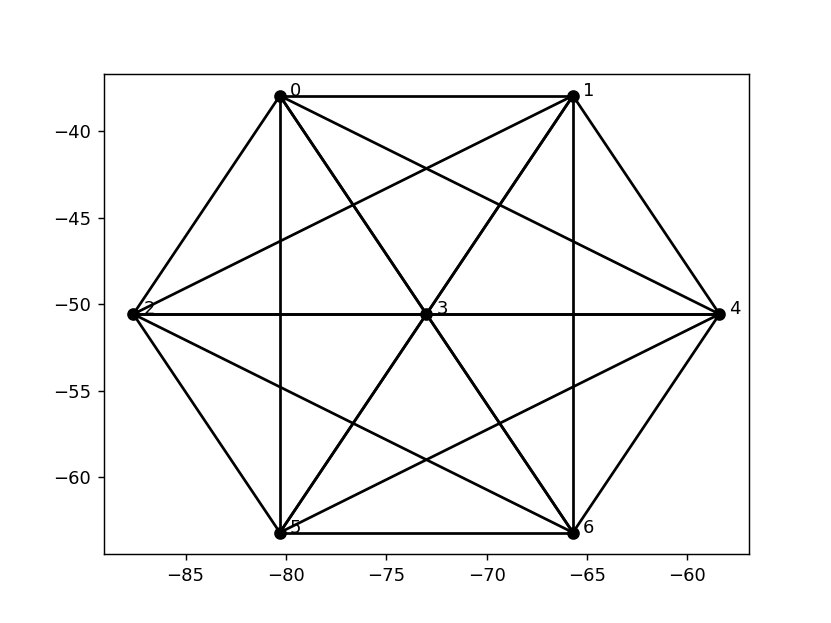

In [14]:
Nants = 7
ants = np.loadtxt('antenna_positions_37.dat')
idxs = np.arange(Nants)
antpos = {}

antpos[0] = ants[0]; antpos[1] = ants[1]
antpos[2] = ants[4]; antpos[3] = ants[5]; antpos[4] = ants[6]
antpos[5] = ants[10]; antpos[6] = ants[11]

plt.figure()
plot_ants(antpos)

redbls = hera_cal.redcal.get_pos_reds(antpos)
for bl in redbls:
    plot_redbl(bl)

<IPython.core.display.Javascript object>


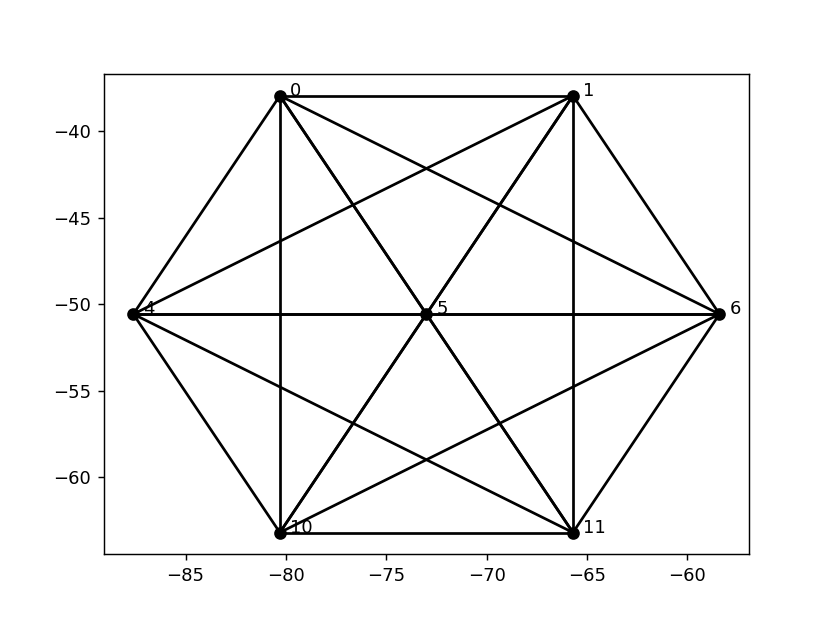

In [17]:
plt.figure()
plot_ants(antpos)

redbls = hera_cal.redcal.get_pos_reds(antpos)
for bl in redbls:
    plot_redbl(bl)

In [18]:
redbls = []
center_ants = [5, 6, 7, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 29, 30, 31]
for ant in center_ants:
    antpos = gen_reds(ant, ants)
    redbls.append(hera_cal.redcal.get_pos_reds(antpos))
redbls = np.concatenate(redbls, axis=0)

(399, 178)


<IPython.core.display.Javascript object>


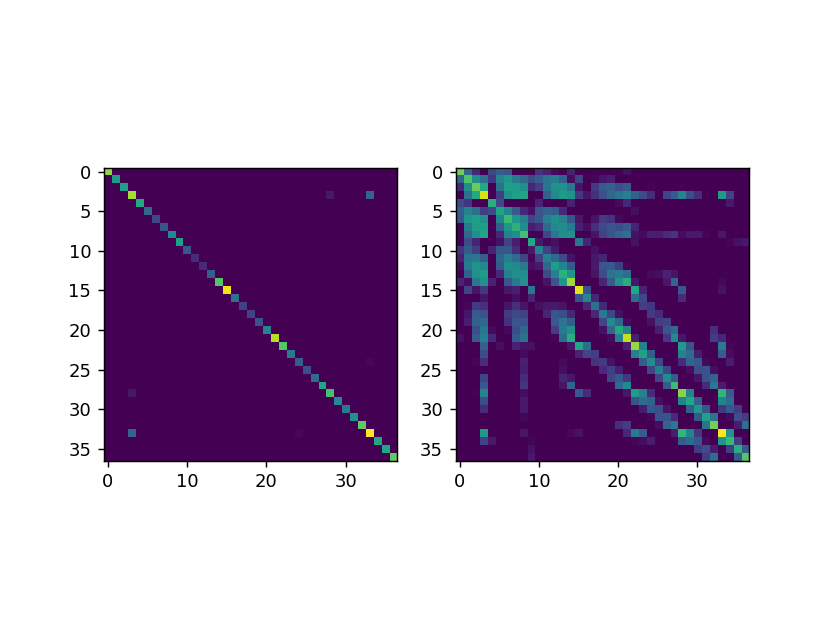

In [20]:
A = genA(redbls)
print np.shape(A)

Mr = np.dot(np.real(A.T), np.real(A))
Mi = np.dot(np.imag(np.conjugate(A.T)), np.imag(A))

plt.figure()
plt.subplot(121)
covr = np.linalg.pinv(Mr)[:37,:37]
plt.imshow(np.log(np.abs(covr)),vmin=-3.6)

plt.subplot(122)
covi = -1*np.linalg.pinv(Mi)[:37,:37]
plt.imshow(np.log(np.abs(covi)),vmin=-3.7)

# Honeycomb grouping

In [3]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v

In [4]:
def distance(ant1, ant2, antlocs):
    try: d = np.sqrt((antlocs[ant1][0]-antlocs[ant2][0])**2 + (antlocs[ant1][1]-antlocs[ant2][1])**2)
    except(KeyError): d = 0
    return d

def neighbours(cen_ant, antpos, dist=14.6, antrange=20):
    """Return upto six antennas that neighbour the center antenna"""
    neighbours = []
    for ant in range(cen_ant-antrange, cen_ant+antrange, 1):
        if np.isclose(distance(ant, cen_ant, antpos), dist):
            neighbours.append(ant)
    return neighbours

def gen_reds(cen_ant,antlocs):
    """Given the center antenna number generate all the redbls for that set."""
    antpos = {}

    antpos[cen_ant] = antlocs[cen_ant]
    for ant in range(37):
        if np.isclose(distance(ant, cen_ant, antlocs), 14.6):
            antpos[ant] = antlocs[ant]
    return antpos

In [30]:
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]+.5,v[1]))

def plot_redbl(redbls):
    for a1,a2 in redbls:
        plt.plot([antpos[a1][0],antpos[a2][0]],[antpos[a1][1],antpos[a2][1]],'k-')

def plot_hex(cen_ant):
    idxs = [0, 1, 3, 5, 4, 2]
    neighants = np.asarray(neighbours(cen_ant, antpos))
    if len(neighants) < 6:
        return
    neighants = neighants[idxs]
    for a1,a2 in zip(neighants,np.roll(neighants,1)):
        try: plt.plot([antpos[a1][0], antpos[a2][0]],[antpos[a1][1], antpos[a2][1]],'k-')
        except(KeyError): pass

In [6]:
center_ants = []
def gen_center_antennas(cen_ant):
    """Return a list of center antennas for a 
    honeycomb radiating from one center antenna"""
    first_layer = neighbours(cen_ant, antpos, dist=25.288, antrange=30)
    flag = 0
    for a1 in first_layer:
        #print a1
        if a1 not in center_ants:
            center_ants.append(a1)
            gen_center_antennas(a1)
        else: flag += 1
    if flag==6:
        return center_ants
    return center_ants

<IPython.core.display.Javascript object>


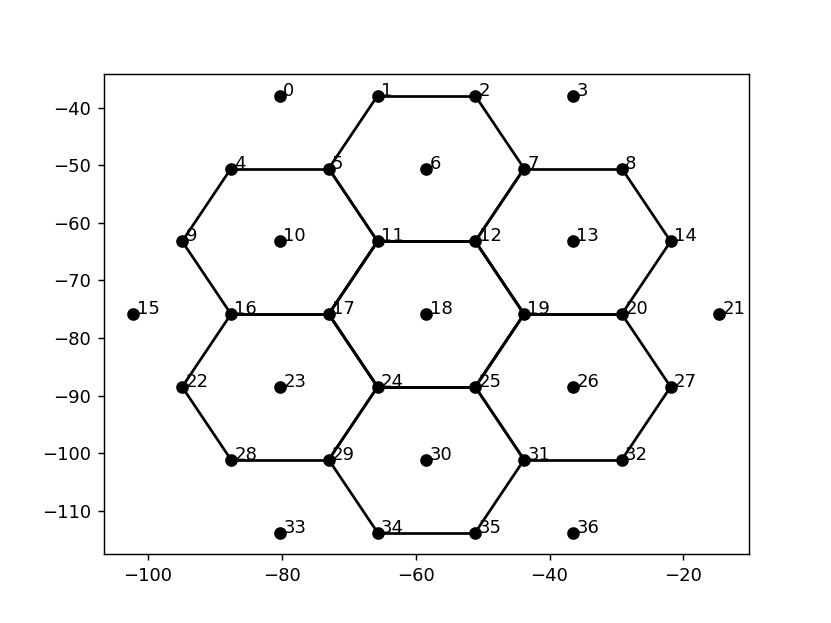

In [7]:
plot_ants(antpos)
plot_hex(18)
center_ants = gen_center_antennas(18)
for ant in center_ants:
    plot_hex(ant)

In [37]:
redbls = []
for ant in center_ants:
    subhex = np.append(ant,neighbours(ant,antpos))
    sub_antpos = {k:v for k,v in antpos.items() if k in subhex}
    redbls.append(hera_cal.redcal.get_pos_reds(sub_antpos))
    #print hera_cal.redcal.get_pos_reds(sub_antpos)
#redbls = np.concatenate(redbls, axis=0)

In [38]:
print len([pair for reds in redbls for bl in reds for pair in bl])
print Nants+9

183
46


In [48]:
def genA_group(redbls):
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls[0])
    
    # number of measurements = total number of baselines
    allbls = [pair for reds in redbls for bl in reds for pair in bl]
    M = len(allbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for subreds in redbls:
        for bl,reds in enumerate(subreds):
            for pair in reds:
                A[i,pair[0]] = (1+1j)
                A[i,pair[1]] = (1-1j)
                A[i,Nants+bl] = 1+1j
                i += 1
    return np.matrix(A)

(183, 46)


<IPython.core.display.Javascript object>


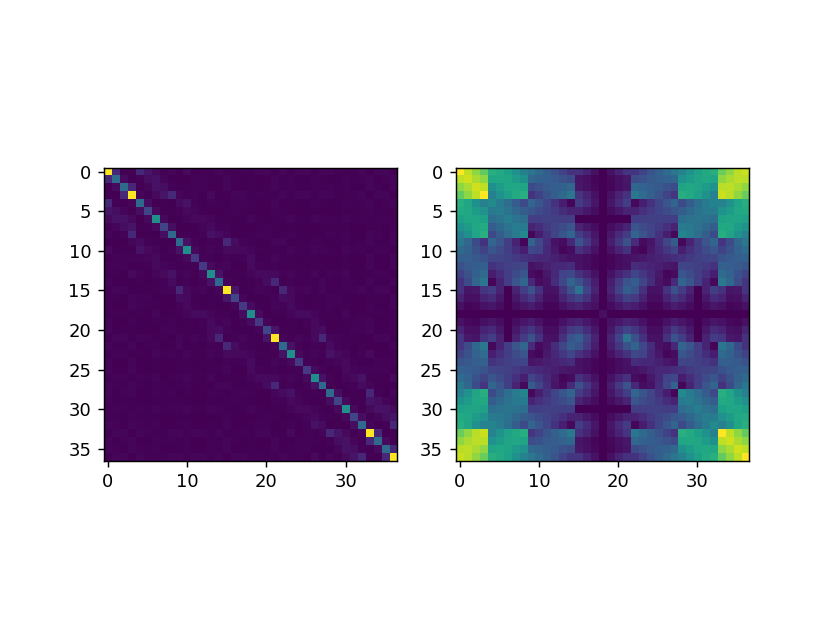

In [50]:
A = genA_group(redbls)
print np.shape(A)

Mr = np.dot(np.real(A.T), np.real(A))
Mi = np.dot(np.imag(np.conjugate(A.T)), np.imag(A))

plt.figure()
plt.subplot(121)
covr = np.linalg.pinv(Mr)[:37,:37]
plt.imshow(np.abs(covr))

plt.subplot(122)
covi = -1*np.linalg.pinv(Mi)[:37,:37]
plt.imshow(np.abs(covi))

<IPython.core.display.Javascript object>


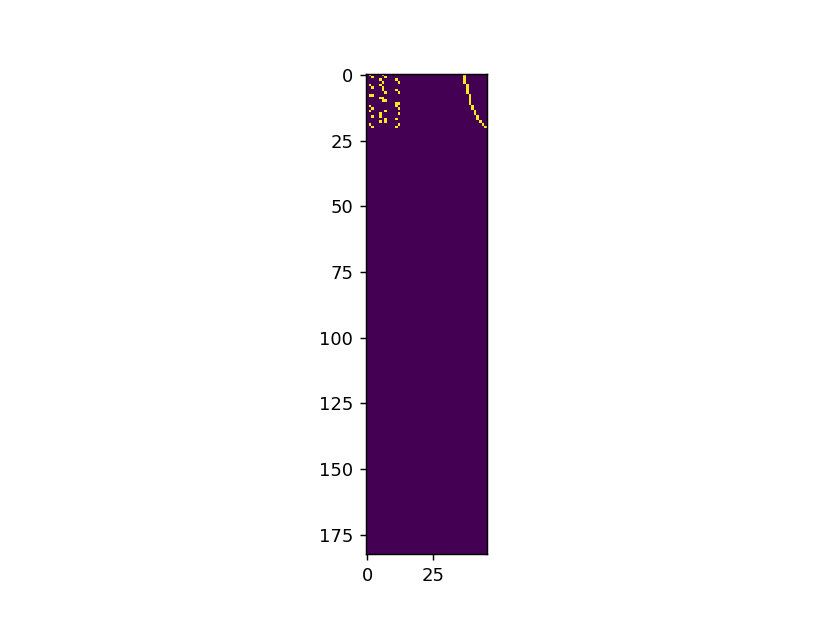

In [29]:
plt.figure()
plt.imshow(np.abs(A))